# Simulating catalogs

This tutorial shows how to generate mock catalogs of Galactic binaries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from corner import corner
from fast_lisa_subtraction.utils import latexify

# Specify the device to use for computations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Simulate a DWD Population

We will make use of the `GalacticBinaryPopulation` class to draw samples of a DWD Population.

This class uses enables the sampling of the parameters describing a catalog of GBs

In particular:
- `Frequency`
- `FrequencyDerivative`
- `Amplitude`
- `InitialPhase`
- `Inclination`
- `Polarization`
- `EclipticLatitude`
- `EclipticLongitude`








the the parametrization explained in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX) and is by default initialized to reproduce the best fit to the catalog of [Lamberts A. et al. (2019)](https://academic.oup.com/mnras/article/490/4/5888/5585418)

### Priors

`FastLisaSubtraction` supports multiple analytical priors, like `Uniform`, `Gaussian`, `Gamma`, `LogNormal` as described in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX)

In [2]:
import fast_lisa_subtraction.priors as priors

print(priors.__all__)

['Uniform', 'LogNormal', 'Gamma', 'PowerLaw', 'BrokenPowerLaw', 'UniformCosine', 'UniformSine', 'Gaussian', 'Cauchy', 'GalacticBinaryPopulation']


In order to generate a mock catalog we need to instanciate the `GalacticBinaryPopulation` class.

We first need to define a dictionary with the prior for each set of parameters, as an example:

In [19]:
from fast_lisa_subtraction.priors import *

prior_dict = dict(
                Frequency           = PowerLaw(alpha=-2.9, minimum=1e-4, maximum=1e-1, name='Frequency', device=device),
                FrequencyDerivative = Gamma(alpha=2, beta=3, offset=-20.0, name='FrequencyDerivative', device=device),
                Amplitude           = LogNormal(mu=-21.5, sigma=0.2, minimum=-24.5, maximum=-20.5, name='Amplitude', device=device),
                InitialPhase        = Uniform(0, 2*np.pi, name='InitialPhase', device=device),
                Inclination         = UniformCosine(0, np.pi, name='Inclination', device=device),
                Polarization        = Uniform(0, 2*np.pi, name='Polarization', device=device),
                EclipticLatitude    = UniformSine(-np.pi/2, np.pi/2, name='EclipticLatitude', device=device),
                EclipticLongitude   = Uniform(0, 2*np.pi, name='EclipticLongitude', device=device)
            )

Then we use the class to sample the marginal and introduce a copula correlation in $f$-$\dot{f}$ as described in [De Santi F. et al (2026)](arxiv.XXXX.XXXXX)

Other available copulas are the `Clayton`, `Frank` and `Student-T`, refer to the documentation page for details

In [21]:
# Instantiate the GalacticBinaryPopulation class
GB_population = GalacticBinaryPopulation(priors=prior_dict, device=device)

# Generate samples from the population
N = int(1e6)
GB_population_samples = GB_population.sample(N, copula=True, kind='gaussian', rho=0.995)

# Convert to a dataframe and inspect the columns
GB_population_df = GB_population_samples.dataframe()

GB_population_df

,Frequency,FrequencyDerivative,Amplitude,InitialPhase,Inclination,Polarization,EclipticLatitude,EclipticLongitude
0,0.000526,1.355755e-19,2.373652e-23,6.150496,0.633865,3.729237,0.050784,4.677835
1,0.000178,1.311480e-20,6.788839e-24,4.855270,2.239879,1.419954,-0.796893,4.445789
2,0.000499,1.435993e-19,2.641336e-23,5.978369,0.470973,5.871028,1.281290,5.492393
3,0.000141,1.170272e-20,5.955619e-24,5.568544,2.221101,4.362195,-1.470888,4.870225
4,0.004057,4.252375e-18,9.537755e-23,3.172446,2.747589,5.739798,0.654771,5.605436
...,...,...,...,...,...,...,...,...
999995,0.000127,8.197637e-21,1.088895e-23,2.308423,2.270534,3.248475,1.324378,3.417033
999996,0.000112,5.760977e-21,9.446358e-24,1.719176,1.119668,3.546948,-0.483979,1.316530
999997,0.000096,4.459325e-21,4.497716e-24,1.306206,2.927927,3.480611,0.136610,2.823656
999998,0.000148,1.354475e-20,2.019698e-23,3.629042,1.202224,2.579357,0.228903,0.055814


In [16]:
GB_population_samples.numpy().shape

(1000000, 8)

We then can plot the distributions

In [ ]:
import copy
from fast_lisa_subtraction.utils import latexify

latex_dict = {
    'Frequency': r'$\log_{10}(f/{\rm Hz})$',
    'FrequencyDerivative': r'$\log_{10}(\dot{f}/{\rm Hz/s})$',
    'Amplitude': r'$\log_{10}\mathcal{A}$',
    'InitialPhase': r'$\phi_0$',
    'Inclination': r'$\iota$',
    'Polarization': r'$\psi$',
    'EclipticLatitude': r'$\beta$',
    'EclipticLongitude': r'$\lambda$',
}

@latexify
def plot_catalogue(pop_samples, **corner_kwargs):
    pop_samples = copy.deepcopy(pop_samples)

    for key in ['Frequency', 'FrequencyDerivative', 'Amplitude']:
        pop_samples[key] = copy.deepcopy(torch.log10(pop_samples[key]))
    
    pop_samples_numpy = pop_samples.numpy()
    latex_labels = [latex_dict[key] for key in pop_samples.keys()]
    
    return corner(pop_samples_numpy, labels=latex_labels, **corner_kwargs)

[WARNING] - Too few points to create valid contours


[[-3.9728861e+00 -2.0255806e+01 -2.3414732e+01 ...  1.2777513e+00
   5.6407464e-01  4.8679118e+00]
 [-3.9606178e+00 -2.0228775e+01 -2.3245405e+01 ...  3.7992871e+00
   4.8841342e-02  1.0111753e+00]
 [-3.8808286e+00 -1.9997635e+01 -2.3164381e+01 ...  1.0886315e+00
   9.8742479e-01  3.0580904e+00]
 ...
 [-3.7445889e+00 -1.9658960e+01 -2.2803177e+01 ...  5.1170163e+00
  -1.2938324e-02  1.4685634e+00]
 [-2.9042597e+00 -1.8071522e+01 -2.2603531e+01 ...  1.6428152e+00
   1.2402518e+00  4.6846504e+00]
 [-3.7871690e+00 -1.9830179e+01 -2.3002216e+01 ...  1.0215857e-01
   7.9208350e-01  2.2080398e+00]]


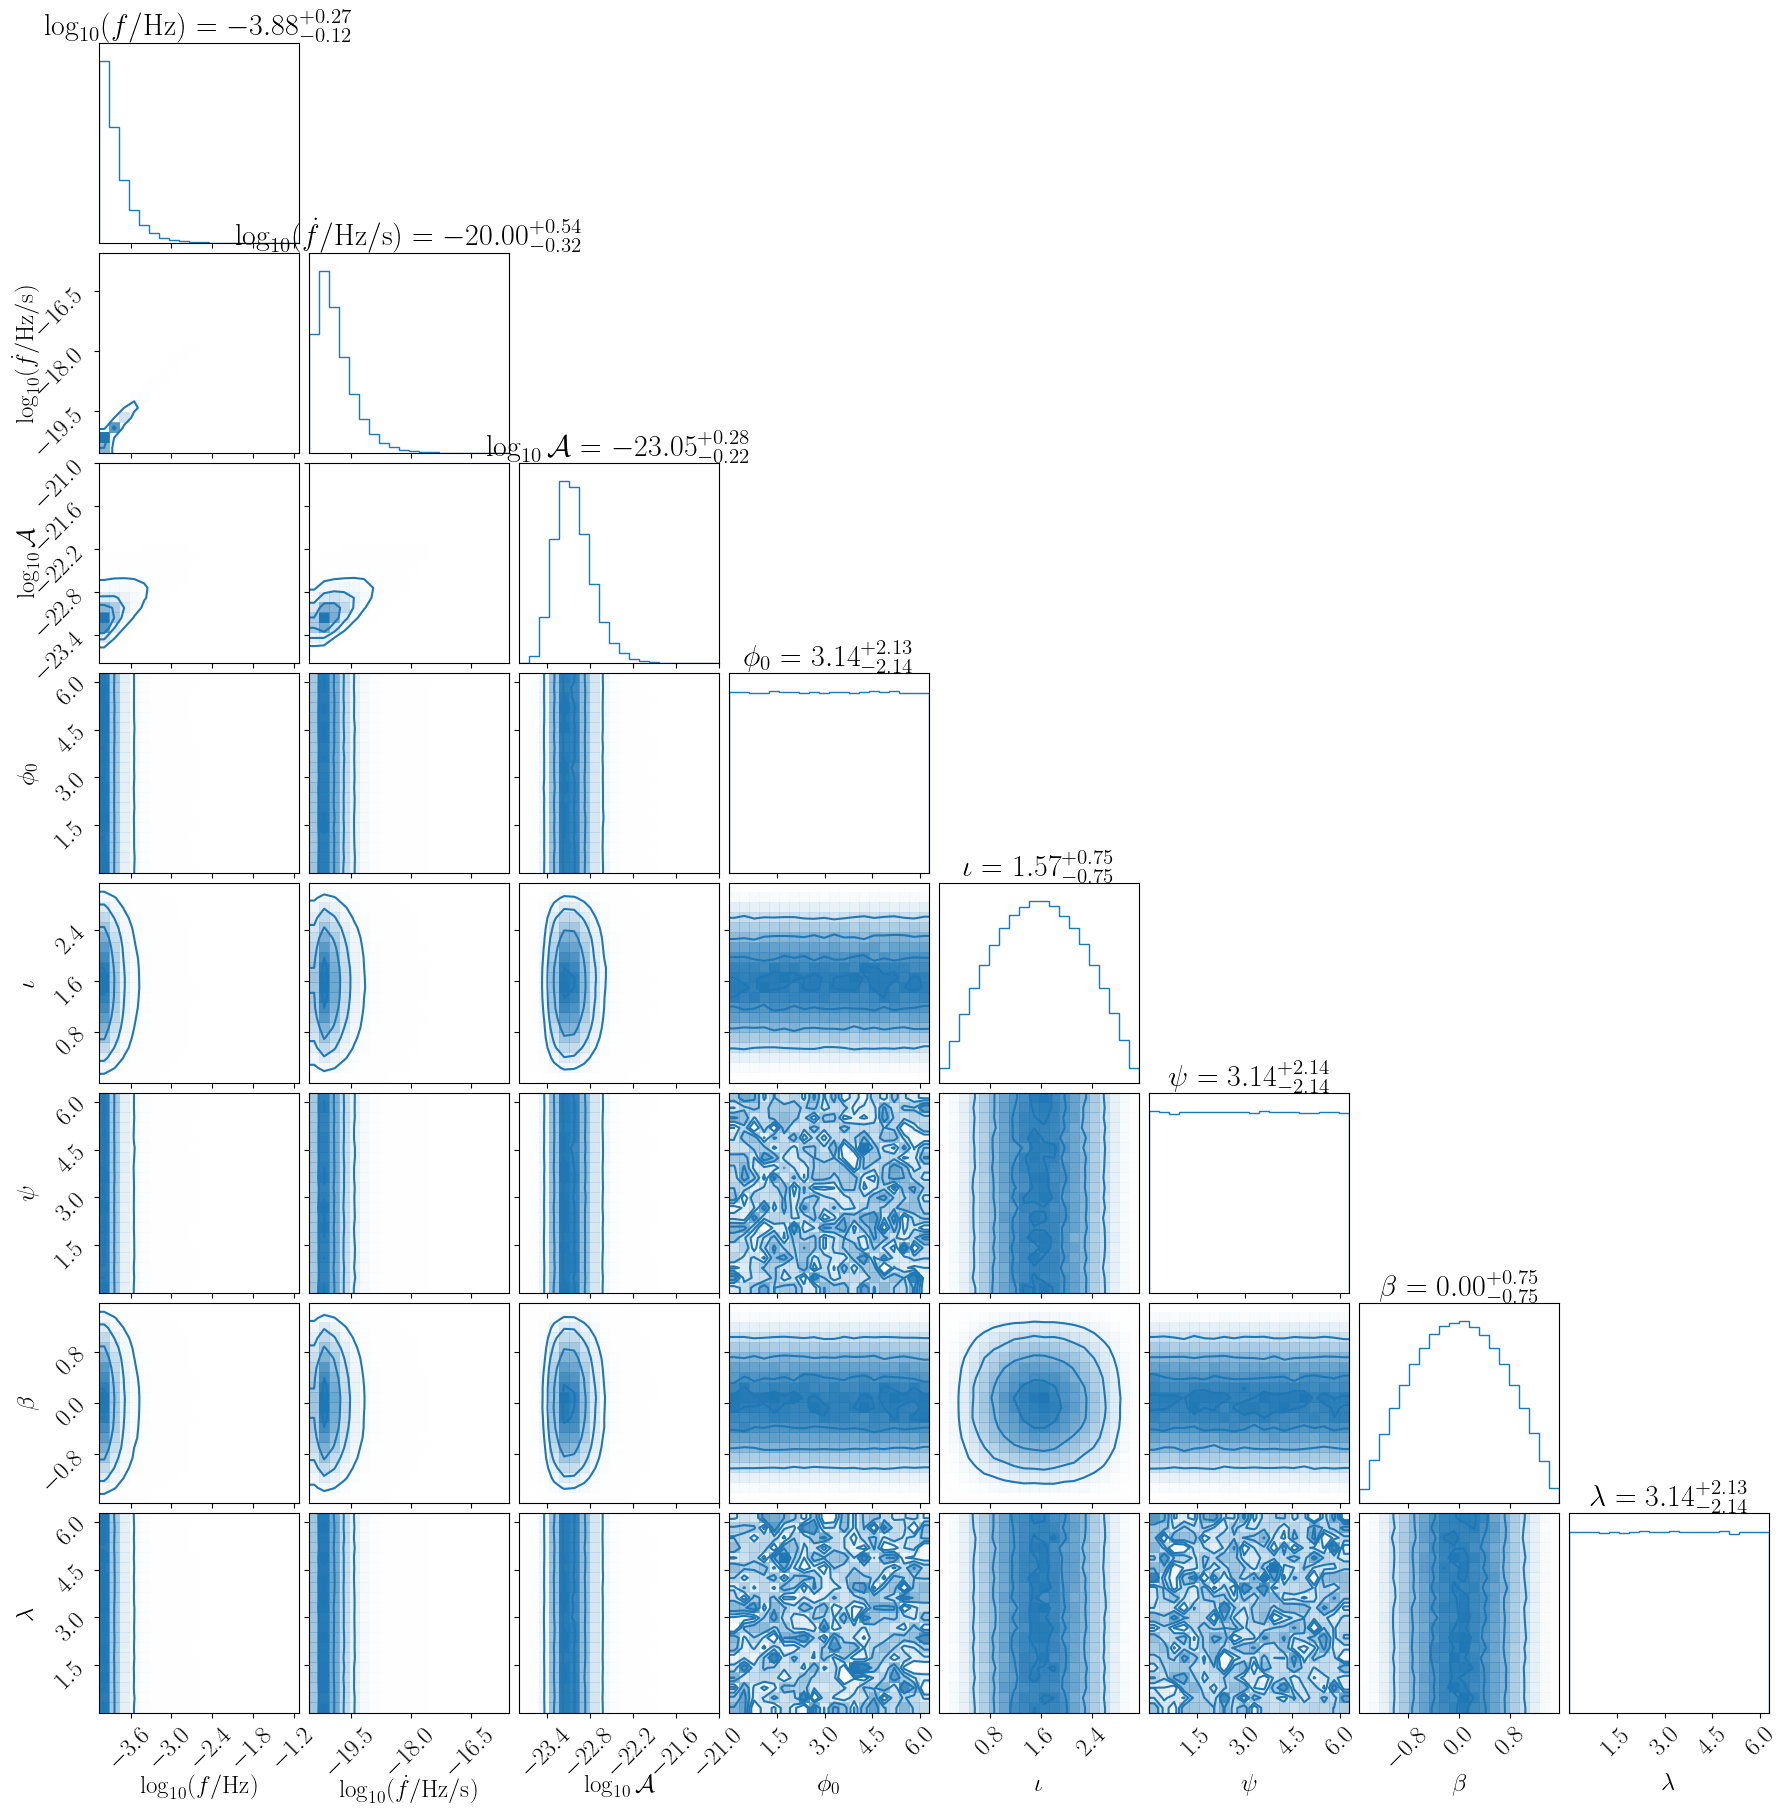

In [18]:
fig = plot_catalogue(GB_population_samples, show_titles=True, color='C0', plot_datapoints=False)